In [ ]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.BatchNorm1d(2048),
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout(p=dropout),
            # nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(512, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(64, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                len = X.shape[0]
                if (i+1) % 100 == 0:
                    print(l)
        #         metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
        #     train_l = metric[0] / metric[2]
        #     train_acc = metric[1] / metric[2]
        #     if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        #         animator.add(epoch + (i + 1) / num_batches,
        #                      (train_l, train_acc, None))
        # test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
        # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        #   f'test acc {test_acc:.3f}')


lr = 0.5
epochs = 3
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
temp = 0
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [2]:
torch.save(net,'10-31-alexnet.pth')
net1 = torch.load('10-31-alexnet.pth')
net1.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net1(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

150.0
154.0
142.0
152.0
159.0
141.0
139.0
143.0
143.0
158.0


In [3]:
148/256

0.578125

tensor(0.6957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

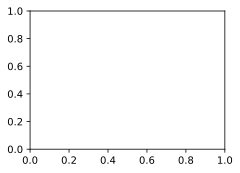

In [3]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.BatchNorm1d(2048),
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout(p=dropout),
            # nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(512, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(64, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                len = X.shape[0]
                if (i+1) % 100 == 0:
                    print(l)
        #         metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
        #     train_l = metric[0] / metric[2]
        #     train_acc = metric[1] / metric[2]
        #     if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        #         animator.add(epoch + (i + 1) / num_batches,
        #                      (train_l, train_acc, None))
        # test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
        # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        #   f'test acc {test_acc:.3f}')


lr = 0.5
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
temp = 0
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [5]:
# torch.save(net,'10-31-alexnet.pth')
# net1 = torch.load('10-31-alexnet.pth')
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

160.0
159.0
163.0
164.0
155.0
150.0
152.0
163.0
151.0
155.0


In [6]:
160/256

0.625

In [ ]:
torch.save(the_model.state_dict(), PATH)
#读取
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))

In [7]:
torch.save(net.state_dict(), '10-31-alexnet_3.pth')

tensor(0.7053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

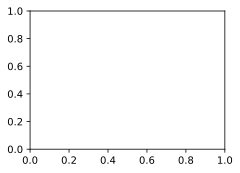

In [5]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=False)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.BatchNorm1d(2048),
            # nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout(p=dropout),
            # nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(512, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(64, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()
net.load_state_dict(torch.load('10-31-alexnet_3.pth'))

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                len = X.shape[0]
                if (i+1) % 100 == 0:
                    print(l)

lr = 0.05
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [6]:
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

145.0
141.0
139.0
129.0
148.0
150.0
138.0
136.0
137.0
141.0


In [7]:
lr = 0.1
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [8]:
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

159.0
144.0
146.0
145.0
160.0
156.0
141.0
148.0
163.0
165.0


In [9]:
torch.save(net.state_dict(), '10-31-alexnet_4.pth')

In [10]:
lr = 0.1
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.2068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [12]:
net = AlexNet()
net.state_dict(torch.load('10-31-alexnet_4.pth'))
lr = 0.05
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
net.cuda()
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.6986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [13]:
lr = 0.05
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
# net.cuda()
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.4756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [14]:
net = AlexNet()
net.state_dict(torch.load('10-31-alexnet_4.pth'))
lr = 0.005
epochs = 1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
net.cuda()
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break
        
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.7223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [5]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=dropout),
            # nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(512, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16), nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(p=dropout),
            nn.Linear(16, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet()

def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                len = X.shape[0]
                if (i+1) % 2000 == 0:
                    print(l)



lr = 0.3
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.BCELoss()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

tensor(0.6893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [4]:
# continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=200:
        break

153.0
152.0
168.0
150.0
140.0
154.0
148.0
152.0
147.0
128.0
159.0
146.0
145.0
150.0
155.0
148.0
153.0
148.0
159.0
145.0
152.0
145.0
152.0
152.0
151.0
164.0
150.0
154.0
159.0
155.0
146.0
158.0
146.0
147.0
152.0
156.0
158.0
157.0
151.0
142.0
142.0
163.0
162.0
155.0
158.0
145.0
133.0
144.0
155.0
153.0
152.0
153.0
154.0
156.0
144.0
135.0
135.0
149.0
162.0
156.0
164.0
148.0
149.0
151.0
152.0
154.0
141.0
158.0
155.0
140.0
159.0
147.0
154.0
154.0
154.0
138.0
161.0
137.0
152.0
156.0
151.0
153.0
159.0
140.0
145.0
151.0
165.0
153.0
150.0
159.0
127.0
154.0
150.0
142.0
146.0
144.0
139.0
155.0
149.0
146.0
146.0
126.0
135.0
141.0
147.0
148.0
157.0
145.0
151.0
146.0
154.0
155.0
149.0
165.0
157.0
137.0
148.0
155.0
161.0
157.0
144.0
159.0
152.0
141.0
140.0
156.0
141.0
158.0
172.0
154.0
149.0
146.0
148.0
154.0
142.0
136.0
157.0
155.0
158.0
151.0
144.0
153.0
142.0
142.0
163.0
157.0
147.0
147.0
145.0
134.0
148.0
161.0
159.0
155.0
146.0
146.0
148.0
157.0
149.0
147.0
146.0
159.0
137.0
135.0
153.0
142.0
157.

In [3]:
lr = 0.01
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.5449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [11]:
lr = 0.001
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break

tensor(0.3227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor

In [ ]:
net.eval()
i = 0
for X, y in testloader:
    X = X.cuda()
    y = y.cuda()
    y_pred = net(X)
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred),torch.zeros_like(y_pred))
    cmp = d2l.astype(y_pred, y.dtype) == y
    print(float(d2l.reduce_sum(d2l.astype(cmp, y.dtype))))
    i += 1
    if i>=10:
        break